# **Assignment 3: DL4NLP**

Done on Google Colaboratory

Answers to questions given at the end of the notebook

In [0]:
import numpy as np
import re
import tensorflow as tf
import datetime
import time
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from keras.models import Model
from keras.activations import relu
from keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D
from keras.layers import Dropout, concatenate


Using TensorFlow backend.


In [0]:
import os
import urllib.request
urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', 'glove.zip')

('glove.zip', <http.client.HTTPMessage at 0x7fc5909f5b70>)

In [0]:
!unzip glove.zip

Archive:  glove.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
def glove_embedding(filename):
  file_glove=open(filename)
  glove={}
  for line in file_glove:
    tmp=line.split()
    word=tmp[0]
    coefficient=np.asarray(tmp[1:], dtype='float')
    glove[word]=coefficient

  file_glove.close()
  return glove


glove=glove_embedding('glove.6B.300d.txt')
print(len(glove))

400000


In [0]:
!pip install -U -q PyDrive 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
#Used Google Drive to store the data files and called them using their URL ids
dataset=drive.CreateFile({'id':'1sZtg74UdDqF7ln8oQ9ML8yt5URJ9Y9M_'})
dataset.GetContentFile('datasetSentences.txt')

dataset=drive.CreateFile({'id':'1pOs1L-cPH4gGOEqxenc1gJmYXpNIWPwJ'})
dataset.GetContentFile('datasetSplit.txt')

dataset=drive.CreateFile({'id':'1R576Zcid3F-03yYrGM0PLVoIbUhMo8zD'})
dataset.GetContentFile('rt-polarity.pos')

dataset=drive.CreateFile({'id':'1ue-3QdyYisYT6gYDk4k6HU3HjTTK4k0B'})
dataset.GetContentFile('rt-polarity.neg')

In [0]:
def clean_str(string):
    """
    Tokenization/string cleaning 
    Function taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


In [0]:
file1="datasetSentences.txt"
read1 = list(open(file1, "r").readlines())
read1 = [s.strip() for s in read1]
x1 = [clean_str(sent) for sent in read1]
data=[]
for line in x1[1:]:
    tmp=line.split(" ",1)
    data.append([int(tmp[0]), tmp[1]])


file2 = "datasetSplit.txt"
read2 = list(open(file2, "r").readlines())
read2 = [s.strip() for s in read2]
#x2 = [clean_str(sent) for sent in read2]
data_split=[]
for line in read2[1:]:
    tmp=line.split(",")
    data_split.append([int(i) for i in tmp])

In [0]:
file3="rt-polarity.pos"
read3=list(open(file3,"r", encoding="latin-1").readlines())
read3=[s.strip() for s in read3]
x3=[clean_str(sent) for sent in read3]

file4="rt-polarity.neg"
read4=list(open(file4,"r",encoding="latin-1").readlines())
read4=[s.strip() for s in read4]
x4=[clean_str(sent) for sent in read4]

labels={}
for line in x3:
    tmp=line.split(".")
    for item in tmp:
        if len(item)>10:
            for i in range(len(data)):
                if item in data[i][1]:
                    labels[data[i][0]]=1


In [0]:
for line in x4:
  tmp=line.split(".")
  for item in tmp:
    if len(item)>10:
      for i in range(len(data)):
        if item in data[i][1]:
          labels[data[i][0]]=0

In [0]:
split={}
train,val,test=0,0,0
for k in labels.keys():
  split[k]=data_split[k-1][1]

In [0]:
x_text=[]
for key in labels.keys():
  x_text.append(data[key-1][1])
  
y=[]
for key in labels.keys():
  if labels[key]==1:
    y.append([0,1])

  else:
    y.append([1,0])
y=np.array(y)

In [0]:
from keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 100000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

#create the word indices
tokenizer.fit_on_texts(x_text)

word_index = tokenizer.word_index

In [0]:
max_sentence_length=100
text_vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sentence_length)
x = np.array(list(text_vocab_processor.fit_transform(x_text)))
print("Text Vocabulary Size: {:d}".format(len(text_vocab_processor.vocabulary_)))

print("x = {0}".format(x.shape))
print("y = {0}".format(y.shape))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Text Vocabulary Size: 16322
x = (9544, 100)
y = (9544, 2)


In [0]:
x_train, x_dev, y_train, y_dev,x_eval,y_eval=[],[],[],[],[],[]
cnt=0
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

for key in split.keys():
  if split[key]==1:
    x_train.append(x_shuffled[cnt])
    y_train.append(y_shuffled[cnt])
  elif split[key]==3:
    x_dev.append(x_shuffled[cnt])
    y_dev.append(y_shuffled[cnt])
  else:
    x_eval.append(x_shuffled[cnt])
    y_eval.append(y_shuffled[cnt])
  cnt+=1
x_train=np.array(x_train)
x_dev=np.array(x_dev)
y_train=np.array(y_train)
y_dev=np.array(y_dev)
x_eval=np.array(x_eval)
y_eval=np.array(y_eval)

In [0]:
def create_embeddings_matrix(embeddings_index, vocabulary, embedding_dim):
    embeddings_matrix = np.random.rand(len(vocabulary)+1, embedding_dim)
    for i, word in enumerate(vocabulary):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector
    return embeddings_matrix

In [0]:
embeddings_matrix = create_embeddings_matrix(glove, word_index, 300)

In [0]:
def get_embeddings_layer(embeddings_matrix, name, max_len, trainable=False):
    embedding_layer = Embedding(input_dim=embeddings_matrix.shape[0],output_dim=embeddings_matrix.shape[1],
        input_length=max_len,weights=[embeddings_matrix],trainable=trainable,name=name)
    return embedding_layer

In [0]:
def get_conv_pool(x_input, max_len, suffix, n_grams=[3,4,5], feature_maps=100):
    branches = []
    for n in n_grams:
        branch = Conv1D(filters=feature_maps, kernel_size=n, activation=relu, name='Conv_'+suffix+'_'+str(n))(x_input)
        branch = MaxPooling1D(pool_size=max_len-n+1, strides=None, padding='valid', name='MaxPooling_'+suffix+'_'+str(n))(branch)
        branch = Flatten(name='Flatten_'+suffix+'_'+str(n))(branch)
        branches.append(branch)
    return branches

In [0]:
def get_cnn_rand(embedding_dim, vocab_size, max_len, num_classes):
    embedding_matrix = np.random.rand(vocab_size, embedding_dim)
    embedding_layer = get_embeddings_layer(embedding_matrix, 'embedding_layer_dynamic', max_len, trainable=True)
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)
    branches = get_conv_pool(x, max_len, 'dynamic')
    z = concatenate(branches, axis=-1)
    z = Dropout(0.5)(z)
    o = Dense(num_classes, activation='sigmoid', name='output')(z)
    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
model_1 = get_cnn_rand(300, len(word_index)+1, 100, 2)

In [0]:
history = model_1.fit(x=x_train, y=y_train, validation_data=(x_dev,y_dev), batch_size=50, epochs=25)

Train on 6843 samples, validate on 893 samples
Epoch 1/25
6843/6843 [==============================] - 5s 694us/step - loss: 0.7569 - acc: 0.5187 - val_loss: 0.6916 - val_acc: 0.4938
Epoch 2/25
6843/6843 [==============================] - 4s 585us/step - loss: 0.6877 - acc: 0.5435 - val_loss: 0.6884 - val_acc: 0.5627
Epoch 3/25
6843/6843 [==============================] - 4s 592us/step - loss: 0.6837 - acc: 0.5595 - val_loss: 0.6807 - val_acc: 0.6086
Epoch 4/25
6843/6843 [==============================] - 4s 588us/step - loss: 0.6678 - acc: 0.5931 - val_loss: 0.6802 - val_acc: 0.5571
Epoch 5/25
6843/6843 [==============================] - 4s 584us/step - loss: 0.6368 - acc: 0.6347 - val_loss: 0.6415 - val_acc: 0.6613
Epoch 6/25
6843/6843 [==============================] - 4s 582us/step - loss: 0.5865 - acc: 0.6930 - val_loss: 0.6267 - val_acc: 0.6450
Epoch 7/25
6843/6843 [==============================] - 4s 587us/step - loss: 0.5181 - acc: 0.7495 - val_loss: 0.5899 - val_acc: 0.6669
E

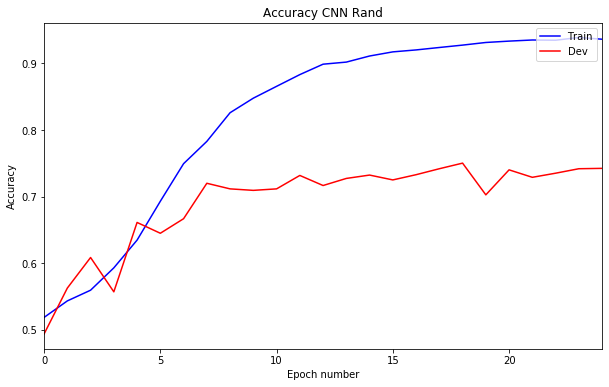

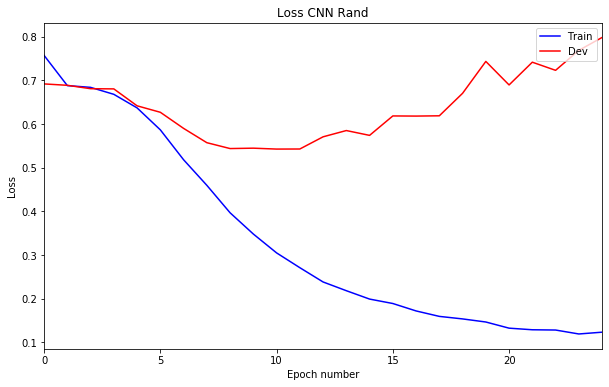

In [0]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(acc)),acc,c='blue',label='Train')
plt.plot(range(len(val_acc)),val_acc,c='red',label='Dev')
plt.margins(x=0)
plt.title('Accuracy CNN Rand')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(loss)),loss,c='blue',label='Train')
plt.plot(range(len(val_loss)),val_loss,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss CNN Rand')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

In [0]:
def get_cnn_pre_trained_embeddings(embedding_layer, max_len, num_classes):
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)
    branches = get_conv_pool(x, max_len, 'static')
    z = concatenate(branches, axis=-1)
    o = Dense(num_classes, activation='sigmoid', name='output')(z)
    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
embedding_layer_static = get_embeddings_layer(embeddings_matrix, 'embedding_layer_static', 100, trainable=False)

In [0]:
model_2 = get_cnn_pre_trained_embeddings(embedding_layer_static, 100, 2)

In [0]:
history = model_2.fit(x=x_train, y=y_train, validation_data=(x_dev,y_dev), batch_size=50, epochs=25)

Train on 6843 samples, validate on 893 samples
Epoch 1/25
6843/6843 [==============================] - 4s 512us/step - loss: 0.6594 - acc: 0.6136 - val_loss: 0.6097 - val_acc: 0.6523
Epoch 2/25
6843/6843 [==============================] - 3s 417us/step - loss: 0.4535 - acc: 0.8114 - val_loss: 0.5831 - val_acc: 0.6937
Epoch 3/25
6843/6843 [==============================] - 3s 415us/step - loss: 0.2936 - acc: 0.9198 - val_loss: 0.5954 - val_acc: 0.6898
Epoch 4/25
6843/6843 [==============================] - 3s 409us/step - loss: 0.1534 - acc: 0.9835 - val_loss: 0.6449 - val_acc: 0.6909
Epoch 5/25
6843/6843 [==============================] - 3s 415us/step - loss: 0.0735 - acc: 0.9975 - val_loss: 0.6225 - val_acc: 0.7100
Epoch 6/25
6843/6843 [==============================] - 3s 412us/step - loss: 0.0362 - acc: 0.9999 - val_loss: 0.6670 - val_acc: 0.7150
Epoch 7/25
6843/6843 [==============================] - 3s 411us/step - loss: 0.0213 - acc: 1.0000 - val_loss: 0.6706 - val_acc: 0.7111
E

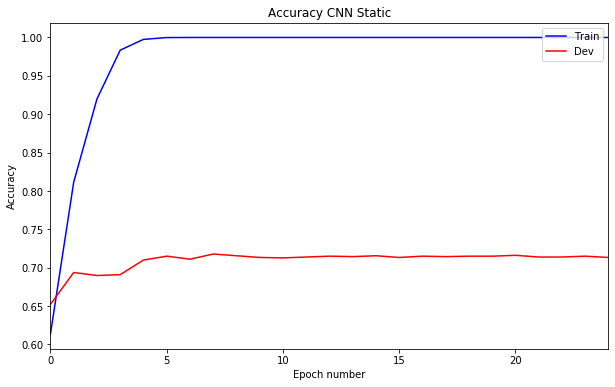

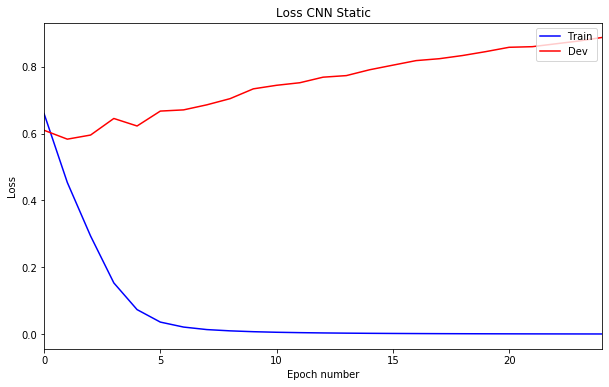

In [0]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(acc)),acc,c='blue',label='Train')
plt.plot(range(len(val_acc)),val_acc,c='red',label='Dev')
plt.margins(x=0)
plt.title('Accuracy CNN Static')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(loss)),loss,c='blue',label='Train')
plt.plot(range(len(val_loss)),val_loss,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss CNN Static')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

In [0]:
embedding_layer_dynamic = get_embeddings_layer(embeddings_matrix, 'embedding_layer_dynamic', 100, trainable=True)

In [0]:
model_3 = get_cnn_pre_trained_embeddings(embedding_layer_dynamic, 100, 2)

In [0]:
history = model_3.fit(x=x_train, y=y_train, validation_data=(x_dev,y_dev), batch_size=50, epochs=25)

Train on 6843 samples, validate on 893 samples
Epoch 1/25
6843/6843 [==============================] - 5s 760us/step - loss: 0.6242 - acc: 0.6485 - val_loss: 0.5751 - val_acc: 0.6971
Epoch 2/25
6843/6843 [==============================] - 4s 590us/step - loss: 0.3450 - acc: 0.8789 - val_loss: 0.5344 - val_acc: 0.7391
Epoch 3/25
6843/6843 [==============================] - 4s 584us/step - loss: 0.1384 - acc: 0.9710 - val_loss: 0.5508 - val_acc: 0.7469
Epoch 4/25
6843/6843 [==============================] - 4s 593us/step - loss: 0.0404 - acc: 0.9985 - val_loss: 0.5887 - val_acc: 0.7581
Epoch 5/25
6843/6843 [==============================] - 4s 584us/step - loss: 0.0142 - acc: 0.9999 - val_loss: 0.6267 - val_acc: 0.7604
Epoch 6/25
6843/6843 [==============================] - 4s 589us/step - loss: 0.0073 - acc: 1.0000 - val_loss: 0.6582 - val_acc: 0.7615
Epoch 7/25
6843/6843 [==============================] - 4s 581us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.6867 - val_acc: 0.7620
E

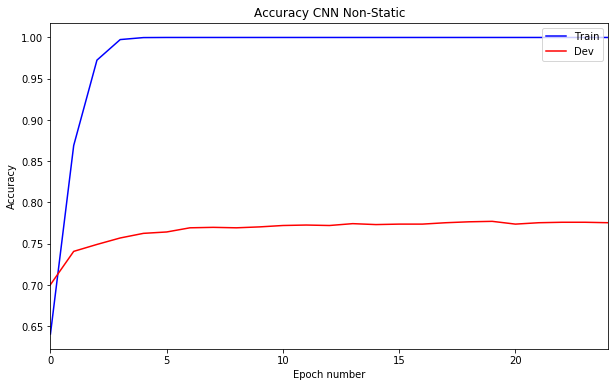

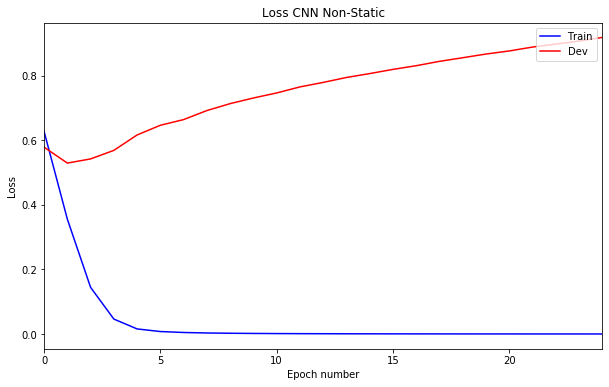

In [0]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(acc)),acc,c='blue',label='Train')
plt.plot(range(len(val_acc)),val_acc,c='red',label='Dev')
plt.margins(x=0)
plt.title('Accuracy CNN Non-Static')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")
plt.show()

fig=plt.subplots(figsize=(10,6))
plt.plot(range(len(loss)),loss,c='blue',label='Train')
plt.plot(range(len(val_loss)),val_loss,c='red',label='Dev')
plt.margins(x=0)
plt.title('Loss CNN Non-Static')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

In [0]:
y_pred = model_3.predict(x_eval, batch_size=50, verbose=1)
print(len(y_pred))

1808/1808 [==============================] - 0s 175us/step
1808


In [0]:
tp,tn,fp,fn=0,0,0,0
for i in range(len(y_pred)):
  if y_pred[i][0]>=y_pred[i][1]:
    y_pred[i][0]=1
  else:
    y_pred[i][1]=1

  if y_pred[i][0]==1 and y_eval[i][0]==1:
    tn+=1
  elif y_pred[i][1]==1 and y_eval[i][1]==1:
    tp+=1
  elif y_pred[i][1]==1 and y_eval[i][0]==1:
    fp+=1
  else:
    fn+=1


In [0]:
print("accuracy="+str((tp+tn)/len(y_pred)))

accuracy=0.7627212389380531


In [0]:
p=tp/(tp+fp)
r=tp/(tp+fn)
print("Precision="+str(p))
print("Recall="+str(r))
print("F1="+str(2*p*r/(p+r)))

Precision=0.7801169590643274
Recall=0.7345814977973568
F1=0.7566647759500851


The sentences present in dataset of Stanford have been mapped to the classes given in the Cornell files by checking every sentence in the Stanford dataset which is greater than length 10 whether it is present in the Cornell files and demarcating positive or negative sentiment.

CNN Non-static method seems to be working the best on the dataset with highest validation accuracy. Hence it is the model used on the test set, which is resulting into an accuracy of 75.6%.

CNN Non-static method seems to be working best due to the fact that the model is updated both weights and embeddings and tuning them for better predictive ability for the task of sentiment classification.